In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6150286974153701859
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14328594432
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16979433912687305085
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [2]:
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
# Define the path to the dataset
dataset_path = "/content/drive/My Drive/Colab Notebooks/CUB_200_2011"

# Read images and labels
image_folder = os.path.join(dataset_path, "images")
label_file = os.path.join(dataset_path, "image_class_labels.txt")
image_name_file = os.path.join(dataset_path, "images.txt")

image_paths = []
labels = []

# Read the label file
with open(label_file, 'r') as file:
    for line in file:
        _, label = line.strip().split(' ')
        labels.append(int(label) - 1)  # Subtract 1 to convert to 0-indexing

# Read the image name file
with open(image_name_file, 'r') as file:
    image_names = file.readlines()
    image_names = [name.strip().split(' ')[1] for name in image_names]
# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
onehot_encoder = OneHotEncoder(sparse=False)
labels_onehot = onehot_encoder.fit_transform(labels_encoded.reshape(-1, 1))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [3]:

images = []
for name in image_names:
    image_path = os.path.join(image_folder, f"{name}")
    image = Image.open(image_path)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_AREA) # Resize images to a consistent size
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    images.append(image)
    print(f"Başarılı: {image_path} görüntüsü yüklendi")

images = np.array(images)
labels = np.array(labels_onehot)

# Split the dataset into train and test sets
train_ratio = 0.8
train_size = int(train_ratio * len(images))

train_images = images[:train_size]
train_labels = labels[:train_size]
test_images = images[train_size:]
test_labels = labels[train_size:]


Görüntülenen çıkış son 5000 satıra kısaltıldı.
Başarılı: /content/drive/My Drive/Colab Notebooks/CUB_200_2011/images/116.Chipping_Sparrow/Chipping_Sparrow_0067_107508.jpg görüntüsü yüklendi
Başarılı: /content/drive/My Drive/Colab Notebooks/CUB_200_2011/images/116.Chipping_Sparrow/Chipping_Sparrow_0070_108281.jpg görüntüsü yüklendi
Başarılı: /content/drive/My Drive/Colab Notebooks/CUB_200_2011/images/116.Chipping_Sparrow/Chipping_Sparrow_0016_109051.jpg görüntüsü yüklendi
Başarılı: /content/drive/My Drive/Colab Notebooks/CUB_200_2011/images/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0056_110848.jpg görüntüsü yüklendi
Başarılı: /content/drive/My Drive/Colab Notebooks/CUB_200_2011/images/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0072_110851.jpg görüntüsü yüklendi
Başarılı: /content/drive/My Drive/Colab Notebooks/CUB_200_2011/images/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0002_110606.jpg görüntüsü yüklendi
Başarılı: /content/drive/My Drive/Colab Notebooks/CUB_200_2011/images/1

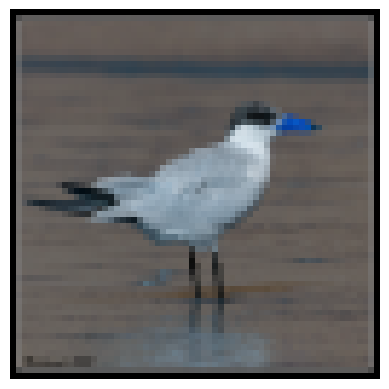

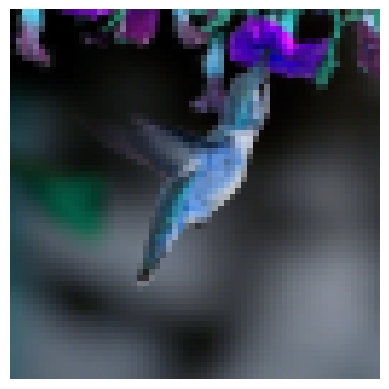

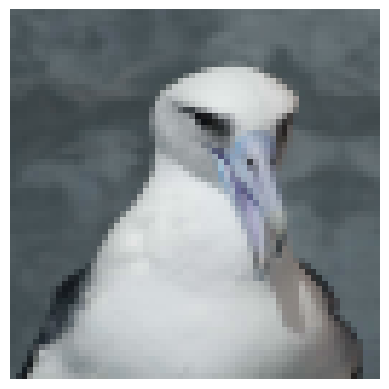

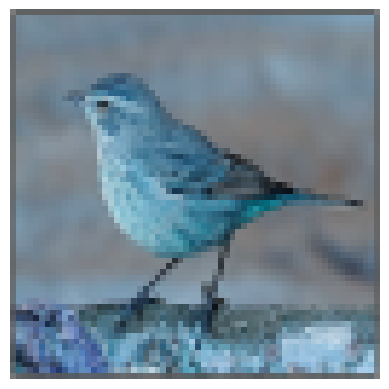

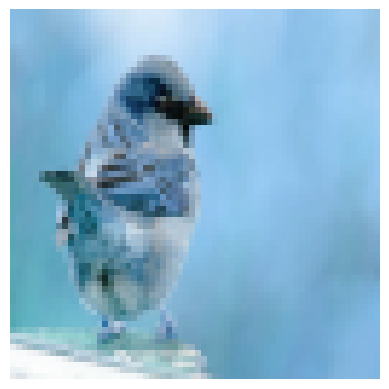

In [4]:
import random
import matplotlib.pyplot as plt
# Randomly display images
num_samples = 5
random_indices = random.sample(range(len(images)), num_samples)
for i in random_indices:
    plt.imshow(images[i])
    plt.axis('off')
    plt.show()

In [5]:
import keras
from keras.optimizers import SGD, RMSprop, Adam
# Define function for model
def create_model():
    input_shape = (64, 64, 3)

    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    # First skip connection
    skip = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Add()([x, skip])  # Adding the skip connection
    x = layers.MaxPooling2D((2, 2))(x)

    # Second skip connection
    skip = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Add()([x, skip])  # Adding the skip connection
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(200, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

model = create_model()
# Perform training experiments using different optimizers
# Experiment 1: Vanilla SGD
model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
print("for optimizer: Vanilla SGD")
# Train the model
model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels))


# Experiment 2: SGD with momentum
model = create_model()
model.compile(optimizer=SGD(momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
print("\nfor optimizer: SGD with momentum")
# Train the model
model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels))


# Experiment 3: RMSProp
model = create_model()
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
print("\nfor optimizer: RMSProp")
# Train the model
model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels))


# Experiment 4: Adam
model = create_model()
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
print("\nfor optimizer: ADAM")
# Train the model
model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels))

for optimizer: Vanilla SGD
Epoch 1/10
295/295 [==============================] - 13s 12ms/step - loss: 5.2719 - accuracy: 0.0059 - val_loss: 5.7320 - val_accuracy: 0.0000e+00
Epoch 2/10
295/295 [==============================] - 3s 11ms/step - loss: 5.2185 - accuracy: 0.0062 - val_loss: 6.2658 - val_accuracy: 0.0000e+00
Epoch 3/10
295/295 [==============================] - 3s 10ms/step - loss: 5.1396 - accuracy: 0.0081 - val_loss: 7.4693 - val_accuracy: 0.0000e+00
Epoch 4/10
295/295 [==============================] - 3s 11ms/step - loss: 5.0928 - accuracy: 0.0085 - val_loss: 7.9506 - val_accuracy: 0.0000e+00
Epoch 5/10
295/295 [==============================] - 3s 10ms/step - loss: 5.0435 - accuracy: 0.0099 - val_loss: 8.1582 - val_accuracy: 0.0000e+00
Epoch 6/10
295/295 [==============================] - 3s 12ms/step - loss: 4.9723 - accuracy: 0.0141 - val_loss: 8.6648 - val_accuracy: 0.0000e+00
Epoch 7/10
295/295 [==============================] - 3s 11ms/step - loss: 4.9008 - accura

I've created a neural architecture that includes convolution, pooling, dense layers, and skip connections. Then, using GoogleColab, the data was trained using 4 different optimizers (Vanilla SGD, SGD with momentum, RMSProp and ADAM). If we evaluate the performance of the optimizers, the order from best to worst is as follows; RMSProp, ADAM, SGD with momentum, vanilla SGD. Especially the accuracy of Vanilla SGD is very low.